In [1]:
import math
import numpy as np
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from seaborn import color_palette
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import models, transforms, utils
from copy import deepcopy

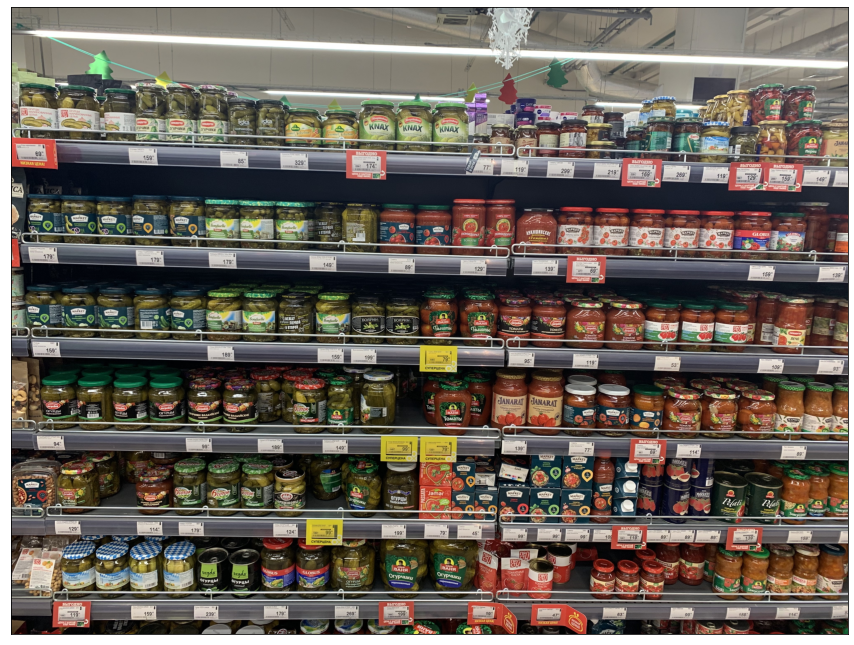

In [2]:
img = cv2.imread('./data/test/IMG_3493.JPG')

plt.figure(figsize = (15,15))
plt.xticks([])
plt.yticks([])
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

In [3]:
class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, path_templates, path_image, downscale_coef, template_coef):
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
                )
            ])
        
        self.path_templates = path_templates
        self.template_names = sorted(os.listdir(path_templates))
        self.path_image = path_image

        self.downscale_coef = downscale_coef
        self.template_coef = template_coef
        
        self.image_raw = cv2.imread(self.path_image)
        self.image_uncompressed = self.image_raw.copy()     
        new_img_h = round(self.image_raw.shape[0] * self.downscale_coef)
        new_img_w = round(self.image_raw.shape[1] * self.downscale_coef)
        self.image_raw = cv2.resize(self.image_raw, (new_img_w, new_img_h), interpolation = cv2.INTER_LINEAR) 
        self.image = self.transform(self.image_raw).unsqueeze(0)
        
    def __len__(self):
        return len(self.templates)
    
    def __getitem__(self, idx):
        template = cv2.imread(self.path_templates + self.template_names[idx])
        new_t_h = round(template.shape[0] * self.downscale_coef * self.template_coef)
        new_t_w = round(template.shape[1] * self.downscale_coef * self.template_coef)      
        template = cv2.resize(template, (new_t_w, new_t_h), interpolation = cv2.INTER_LINEAR)
        template = self.transform(template).unsqueeze(0)
        return {'image': self.image, 
                'image_raw': self.image_raw, 
                'image_unc': self.image_uncompressed, 
                'image_path': self.path_image,
                'template': template, 
                'template_name': self.template_names[idx], 
                'template_h': template.shape[-2],
                'template_w': template.shape[-1]}

In [4]:
# Согласно статье в качестве features берутся выходы второй свертки в первом блоке и 
# четвертой свертки в третьем блоке vgg19, что является слоями с индексом 2 и 16 в версии vgg19
# в PyTorch соответственно.
class FeatureExtractor():
    def __init__(self, model, device):
        self.device = device
        self.model = deepcopy(model.eval())
        self.model = self.model[:17]
        for param in self.model.parameters():
            param.requires_grad = False
        self.model.to(device)
        
        # register_forward_hook позволяет сохранить выходы с промежуточных слоев
        self.model[2].register_forward_hook(self.save_feature_from_layer_2)
        self.model[16].register_forward_hook(self.save_feature_from_layer_16)
        
    def save_feature_from_layer_2(self, module, input, output):
        self.feature_from_layer_2 = output.detach()
    
    def save_feature_from_layer_16(self, module, input, output):
        self.feature_from_layer_16 = output.detach()
        
    def extract_features(self, input):
        input.to(self.device)
        _ = self.model(input)
        # Приводим feature maps к одному размеру
        self.feature_from_layer_2 = F.interpolate(self.feature_from_layer_2,
                                                  # (batch_size, n_feat_maps, h, w)
                                                  size=(self.feature_from_layer_16.shape[2], 
                                                        self.feature_from_layer_16.shape[3]), 
                                                  mode='bilinear', 
                                                  align_corners=True)
        # (batch_size, 320, h, w)
        return torch.cat((self.feature_from_layer_2, self.feature_from_layer_16), dim=1) 

In [5]:
# Нормализация, использованная авторами статьи
def normalize(x1, x2):
    b, _, H, W = x1.shape
    _, _, h, w = x2.shape
    x1 = x1.view(b, -1, H*W)
    x2 = x2.view(b, -1, h*w)
    concat = torch.cat((x1, x2), dim=2)
    x_mean = torch.mean(concat, dim=2, keepdim=True)
    x_std = torch.std(concat, dim=2, keepdim=True)
    x1 = (x1 - x_mean) / x_std
    x2 = (x2 - x_mean) / x_std
    x1 = x1.view(b, -1, H, W)
    x2 = x2.view(b, -1, h, w)
    return (x1, x2)

In [6]:
def compute_score( x, w, h ):
    k = np.ones( (h, w) )
    score = cv2.filter2D(x, -1, k)
    score[:, :w//2] = 0
    score[:, math.ceil(-w/2):] = 0
    score[:h//2, :] = 0
    score[math.ceil(-h/2):, :] = 0
    return score

In [7]:
class QATM_Model():
    def __init__(self, alpha, model):
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.alpha = alpha
        self.feature_extractor = FeatureExtractor(model, self.device)
        
    def match(self, template, image, image_name):
        conf_maps = None
        I_feat = self.feature_extractor.extract_features(image)
        T_feat = self.feature_extractor.extract_features(template)    
        I_feat_norm, T_feat = normalize(I_feat, T_feat)
        patchwise_similarity = torch.einsum('bfhw,bfHW->bhwHW', 
                                I_feat_norm / torch.norm(I_feat_norm, dim=1, keepdim=True), 
                                T_feat / torch.norm(T_feat, dim=1, keepdim=True))     
        batch_size, img_row, img_col, tmpl_row, tmpl_col = patchwise_similarity.shape
        x = patchwise_similarity.view(batch_size, img_row*img_col, tmpl_row*tmpl_col)                       
        xm_img = x - torch.max(x, dim=1, keepdim=True)[0]
        conf_img = F.softmax(self.alpha*xm_img, dim=1)
        xm_tmpl = x - torch.max(x, dim=2, keepdim=True)[0]
        conf_tmpl = F.softmax(self.alpha*xm_tmpl, dim=2)
        confidence = torch.sqrt(conf_img * conf_tmpl)
        conf_values, ind3 = torch.topk(confidence, 1)
        ind1, ind2 = torch.meshgrid(torch.arange(batch_size), 
                                    torch.arange(img_row*img_col), 
                                    indexing='ij')
        ind1 = ind1.flatten()
        ind2 = ind2.flatten()
        ind3 = ind3.flatten()
        ind1 = ind1.to(self.device)
        ind2 = ind2.to(self.device)
        conf_map = confidence[ind1, ind2, ind3]
        conf_map = torch.reshape(conf_map, [batch_size, img_row, img_col, 1])
        if conf_maps is None:
            conf_maps = conf_map
        else:
            conf_maps = torch.cat([conf_maps, conf_map], dim=0)
        return conf_maps
    
    def nms(self, scores, w_array, h_array, thresh):
        indices = np.arange(scores.shape[0])
        maxes = np.max(scores.reshape(scores.shape[0], -1), axis=1)
        scores_omit = scores[maxes > 0.1 * maxes.max()]
        indices_omit = indices[maxes > 0.1 * maxes.max()]
        dots = None
        dos_indices = None
        for index, score in zip(indices_omit, scores_omit):
            dot = np.array(np.where(score >= thresh*score.max()))
            if dots is None:
                dots = dot
                dots_indices = np.ones(dot.shape[-1]) * index
            else:
                dots = np.concatenate([dots, dot], axis=1)
                dots_indices = np.concatenate([dots_indices, np.ones(dot.shape[-1]) * index], axis=0)
        dots_indices = dots_indices.astype(int)
        x1 = dots[1] - w_array[dots_indices]//2
        x2 = x1 + w_array[dots_indices]
        y1 = dots[0] - h_array[dots_indices]//2
        y2 = y1 + h_array[dots_indices]

        areas = (x2 - x1 + 1) * (y2 - y1 + 1)
        scores = scores[dots_indices, dots[0], dots[1]]
        order = scores.argsort()[::-1]
        dots_indices = dots_indices[order]

        keep = []
        keep_index = []
        while order.size > 0:
            i = order[0]
            index = dots_indices[0]
            keep.append(i)
            keep_index.append(index)
            xx1 = np.maximum(x1[i], x1[order[1:]])
            yy1 = np.maximum(y1[i], y1[order[1:]])
            xx2 = np.minimum(x2[i], x2[order[1:]])
            yy2 = np.minimum(y2[i], y2[order[1:]])

            w = np.maximum(0.0, xx2 - xx1 + 1)
            h = np.maximum(0.0, yy2 - yy1 + 1)
            inter = w * h
            ovr = inter / (areas[i] + areas[order[1:]] - inter)

            inds = np.where(ovr <= 0.05)[0]
            order = order[inds + 1]
            dots_indices = dots_indices[inds + 1]

        boxes = np.array([[x1[keep], y1[keep]], [x2[keep], y2[keep]]]).transpose(2,0,1)
        return boxes, np.array(keep_index)

    def plot_result(self, image_raw, ds_coef, image_name, boxes, indices):
        img = image_raw.copy()
        color_list = color_palette('hls', indices.max()+1)
        color_list = list(map(lambda x: (int(x[0]*255), int(x[1]*255), int(x[2]*255)), color_list))
        for i in range(len(indices)):
            for box in boxes[i][None, :,:]:
                box[0][0] /= ds_coef
                box[0][1] /= ds_coef
                box[1][0] /= ds_coef
                box[1][1] /= ds_coef
                img = cv2.rectangle(img, tuple(box[0]), tuple(box[1]), color_list[indices[i]], 4)
                img = cv2.putText(img, image_name[indices[i]], (int(box[0][0]), int(box[0][1])-10), 
                                    cv2.FONT_HERSHEY_SIMPLEX, 
                                    0.7, color_list[indices[i]], 3)
        return img
 
    def run(self, dataset):
        scores = []
        w_array = []
        h_array = []
        for data in dataset:
            val = self.match(data['template'],  data['image'], data['image_path']).to('cpu').numpy()
            val = np.log(val)
            gray = val[0,:,:,0]
            gray = cv2.resize(gray, (data['image'].shape[-1], data['image'].shape[-2]))
            h = data['template'].shape[-2]
            w = data['template'].shape[-1]
            score = compute_score(gray, w, h) 
            score[score>-1e-7] = score.min()
            score = np.exp(score / (h*w))
            scores.append(score)
            w_array.append(data['template_w'])
            h_array.append(data['template_h'])
        threshold = 1.0
        boxes, indices = self.nms(np.array(scores),
                                  np.array(w_array),
                                  np.array(h_array), 
                                  threshold)
        img = self.plot_result(dataset.image_uncompressed, 
                               dataset.downscale_coef, 
                               dataset.template_names, 
                               boxes, 
                               indices)
        return img

In [8]:
template_dir = './data/train_1/'
image_path = './data/test/IMG_3493.JPG'

downscale = 0.4
template_coef = 0.085

dataset = ImageDataset(template_dir, image_path, downscale, template_coef)

model = QATM_Model(model=models.vgg19(pretrained=True).features, alpha=25)

output_image = model.run(dataset)

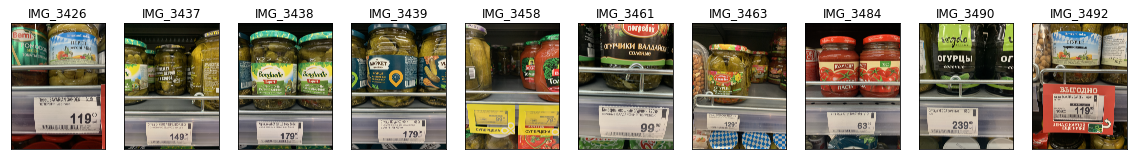

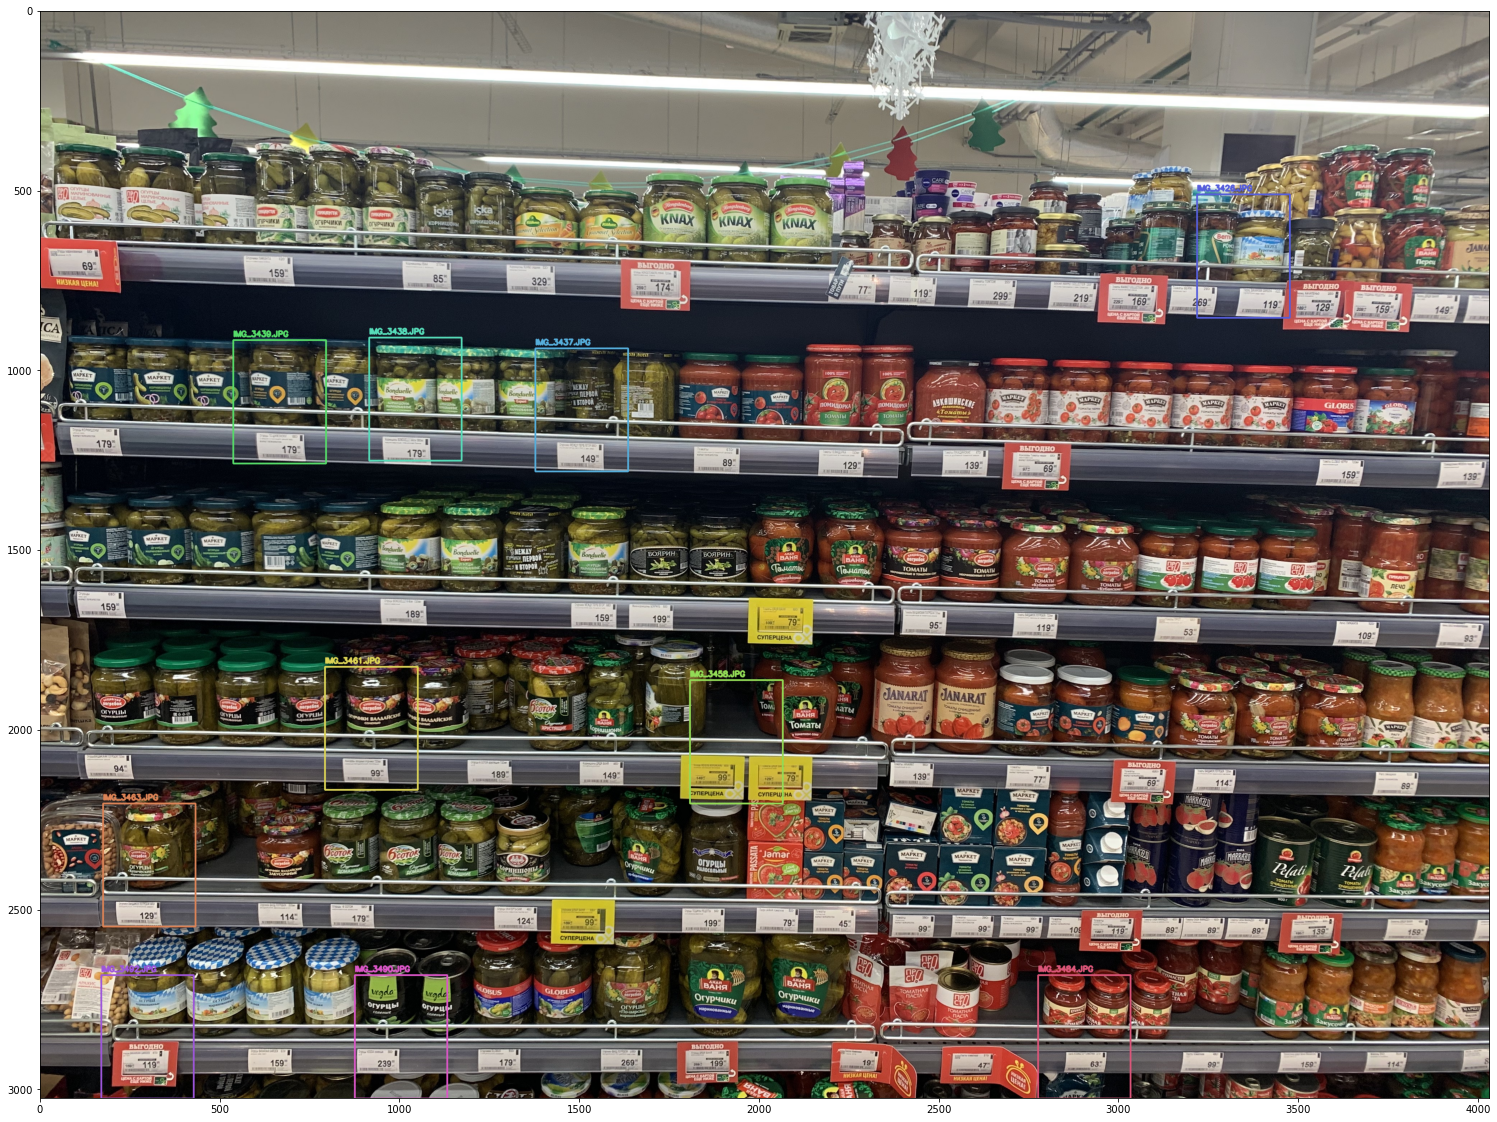

In [9]:
Img = cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB)

templates = sorted(os.listdir(template_dir))
plt.figure(figsize=(20, 10))
for i, temp in enumerate(templates):
    template = cv2.imread(template_dir + temp)
    plt.subplot(1, len(templates), i+1)
    plt.imshow(cv2.cvtColor(template, cv2.COLOR_BGR2RGB))
    plt.title(temp[:-4]), plt.xticks([]), plt.yticks([])
plt.show()

plt.figure(figsize=(30,20))
plt.imshow(Img)
plt.show()

In [10]:
cv2.imwrite('full_image.jpg', Img[:,:,::-1])
pass